In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
import pandas as pd
import scanpy as sc
from anndata import AnnData
from jax import random
from numpyro.infer import MCMC, NUTS

In [2]:
%load_ext autoreload
%autoreload 2

import pertpy as pt

# Toy data

In [72]:
def generate_toy_data_2(n_guides=3, n_cells_per_group=50):
    dats = []
    for i in range(n_guides):
        # Simulate positive and negative population for each guide
        key = random.PRNGKey(i)
        key1, key2 = random.split(key)

        # Negative first
        poisson_data = random.poisson(key1, lam=0.1, shape=n_cells_per_group * i).astype(jnp.float32)

        # Positive
        gaussian_data = random.normal(key2, shape=n_cells_per_group) * 1.0 + 3
        gaussian_data = gaussian_data.clip(0.0, None)

        # Negative second
        poisson_data_ = random.poisson(key1, lam=0.1, shape=(n_cells_per_group * (n_guides - i - 1))).astype(
            jnp.float32
        )

        # The count vector for one guide is the concatenation of the negative and positive populations
        guide_data = jnp.hstack([poisson_data, gaussian_data, poisson_data_])
        dats.append(guide_data)
    guide_counts = np.array(jnp.vstack(dats)).T

    # Combine Poisson and Gaussian data into one dataset
    adata = AnnData(
        guide_counts,
        obs=pd.DataFrame(index=[f"cell{i+1}" for i in range(guide_counts.shape[0])]),
        var=pd.DataFrame(index=[f"guide{i+1}" for i in range(guide_counts.shape[1])]),
    )
    adata.obs["ground_truth"] = ["guide" + str(i + 1) for i in range(n_guides) for _ in range(n_cells_per_group)]
    return adata

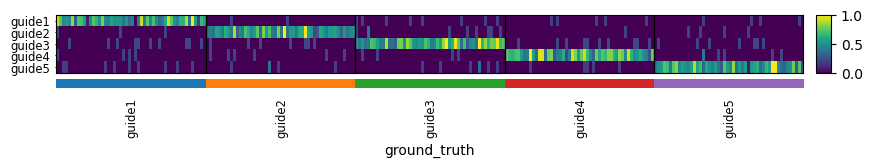

In [79]:
adata = generate_toy_data_2(n_guides=5, n_cells_per_group=50)
sc.pl.heatmap(
    adata, groupby="ground_truth", cmap="viridis", standard_scale="var", var_names=adata.var_names, swap_axes=True
)

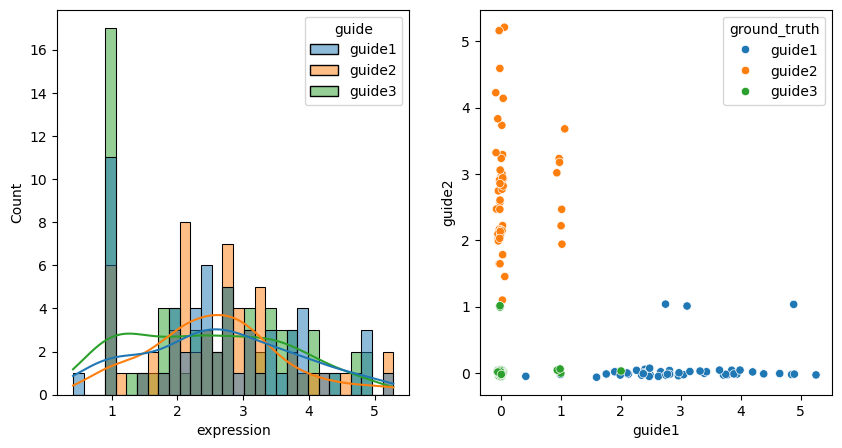

In [80]:
df = bdata.to_df().stack().reset_index().rename(columns={"level_0": "cell", "level_1": "guide", 0: "expression"})
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
df = df[df.expression > 0]
sns.histplot(df, x="expression", hue="guide", bins=30, kde=True, ax=axs[0])
df = bdata.to_df()
df = np.random.normal(0, 0.03, df.shape) + df
sns.scatterplot(data=df, x="guide1", y="guide2", hue=bdata.obs["ground_truth"], ax=axs[1])
plt.show()

In [120]:
ga = pt.pp.GuideAssignment()
ga.assign_mixture_model(bdata)

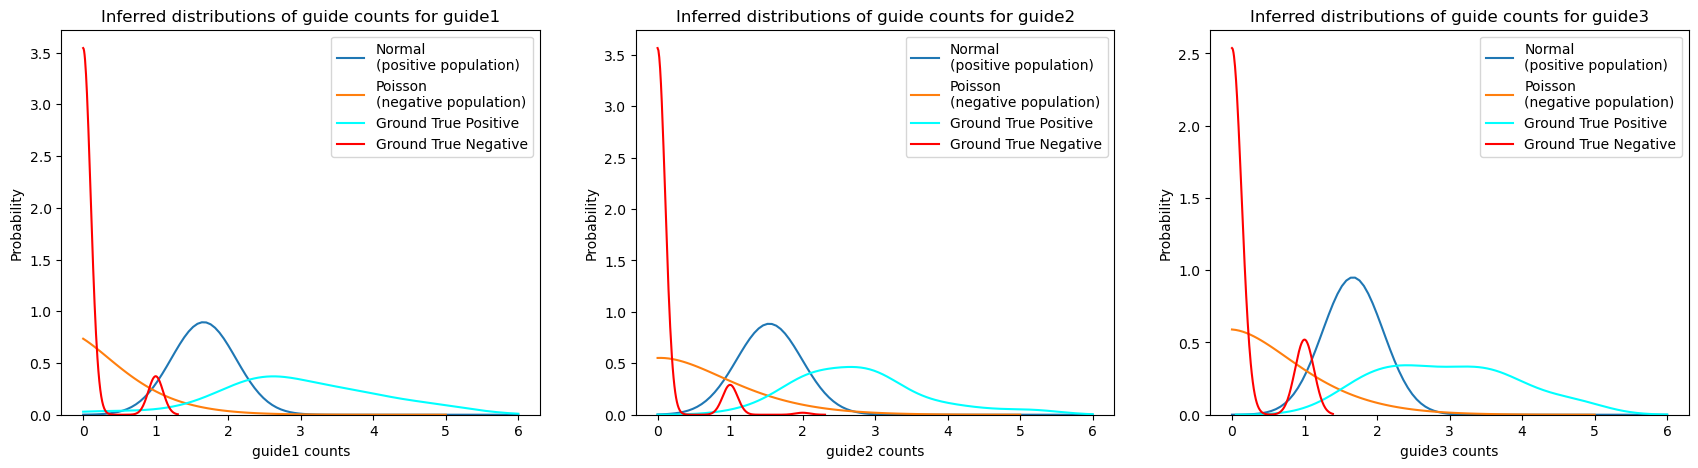

In [149]:
# plot probability distributions of model
n_guides = len(bdata.var_names)
guides = bdata.var_names
fig, axs = plt.subplots(1, n_guides, figsize=(7 * n_guides, 5))
for ax, guide in zip(axs, guides, strict=False):
    # plot gaussian distribution
    x = np.linspace(0, 6, 100)
    y = dist.Normal(
        bdata.uns["guide_assignment_params"][guide]["gaussian_mean"],
        bdata.uns["guide_assignment_params"][guide]["gaussian_std"],
    ).log_prob(x)
    ax.plot(x, np.exp(y), label="Normal\n(positive population)")
    # plot poisson distribution
    x = np.linspace(0, 5, 100)
    y = dist.Poisson(bdata.uns["guide_assignment_params"][guide]["poisson_rate"]).log_prob(x)
    ax.plot(x, np.exp(y), label="Poisson\n(negative population)")
    # Plot ground truth empirical distribution
    sns.kdeplot(
        np.ravel(adata[adata.obs.ground_truth == guide, guide].X),
        color="cyan",
        label="Ground True Positive",
        ax=ax,
        clip=(0, 6),
    )
    sns.kdeplot(
        np.ravel(adata[adata.obs.ground_truth != guide, guide].X),
        color="red",
        label="Ground True Negative",
        ax=ax,
        clip=(0, 6),
    )

    ax.set_xlabel(f"{guide} counts")
    ax.set_ylabel("Probability")
    ax.legend()
    ax.set_title(f"Inferred distributions of guide counts for {guide}")

plt.show()

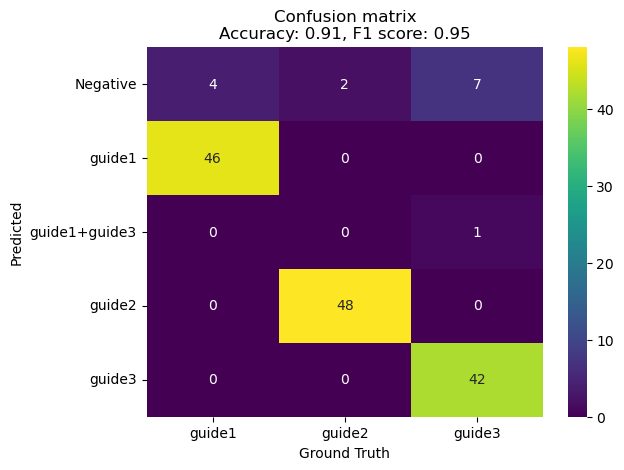

In [150]:
# evaluate accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

accuracy = accuracy_score(bdata.obs["ground_truth"], bdata.obs["assigned_guide"])
f1 = f1_score(bdata.obs["ground_truth"], bdata.obs["assigned_guide"], average="weighted")

labels = np.unique(bdata.obs["assigned_guide"])
cm = confusion_matrix(bdata.obs["ground_truth"], bdata.obs["assigned_guide"], labels=labels)
cm = pd.DataFrame(cm, index=labels, columns=labels).loc[bdata.obs["ground_truth"].unique()]
ax = sns.heatmap(cm.T, annot=True, fmt="d", cmap="viridis")
ax.set_ylabel("Predicted")
ax.set_xlabel("Ground Truth")
plt.title(f"Confusion matrix\nAccuracy: {np.round(accuracy, 2)}, F1 score: {np.round(f1, 2)}")
plt.show()

In [151]:
bdata.obs["assigned_guide"].value_counts()

assigned_guide
guide2           48
guide1           46
guide3           42
Negative         13
guide1+guide3     1
Name: count, dtype: int64

# With real data

In [152]:
mdata = pt.data.papalexi_2021()
# seems like an error in the original data
from scipy.sparse import csr_matrix

mdata.mod["gdo"].X = csr_matrix(mdata.mod["gdo"].X.todense() - 1)
gdo = mdata.mod["gdo"]
gdo.layers["counts"] = gdo.X.copy()
# sc.pp.log1p(gdo)
gdo.var["guide_counts"] = gdo.X.sum(0).A1

subdata = gdo[:, gdo.var.index[:10]].copy()

/home/peidli/miniconda3/envs/pertpy_dev/lib/python3.10/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/peidli/miniconda3/envs/pertpy_dev/lib/python3.10/site-packages/mudata/_core/mudata.py:931: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/home/peidli/miniconda3/envs/pertpy_dev/lib/python3.10/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push

In [ ]:
# TODO: I did something that made this ultra mega slow.
ga = pt.pp.GuideAssignment()
ga.assign_mixture_model(subdata, verbose=True, output_key="mixture_model_assignment")

Output()

In [20]:
subdata.obs.mixture_model_assignment[subdata.obs.mixture_model_assignment.str.contains("+", regex=False)]

index
l3_GAACCTACAAGTCTGT    CUL3g2+CMTM6g2
l6_GGCCGATCAAAGTCAA      CMTM6g1+NTg1
l6_TAAGTGCGTGACTACT      CMTM6g1+NTg3
l7_AACTCAGCAAGCGAGT       CUL3g1+NTg3
l7_AGAGCGAGTATAGGGC      CMTM6g3+NTg1
l7_CACAAACCATGCCCGA      CMTM6g1+NTg1
l8_TTCGGTCAGAACAACT       CUL3g1+NTg3
Name: mixture_model_assignment, dtype: object

In [21]:
ga.assign_to_max_guide(subdata, assignment_threshold=1, output_key="max_assignment")

# Calculate jaccard similarity between the two assignments
from sklearn.metrics import jaccard_score

jac = jaccard_score(subdata.obs["mixture_model_assignment"], subdata.obs["max_assignment"], average="weighted")
print(f"Jaccard similarity between max assignment and mixture assignment: {np.round(jac, 2)}")

Jaccard similarity between max assignment and mixture assignment: 0.89


/home/peidli/miniconda3/envs/pertpy_dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/peidli/miniconda3/envs/pertpy_dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


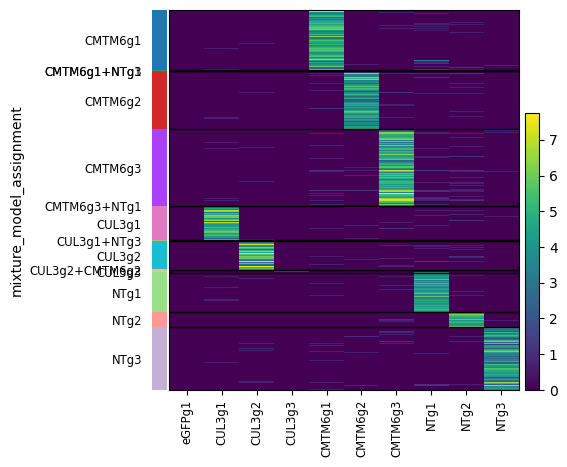

/home/peidli/miniconda3/envs/pertpy_dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/peidli/miniconda3/envs/pertpy_dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


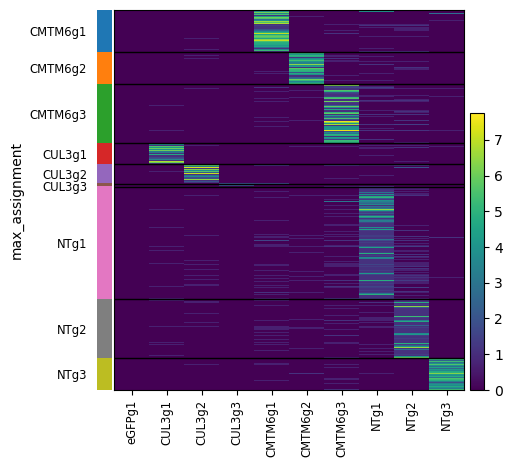

In [22]:
sc.pl.heatmap(
    subdata[subdata.obs.mixture_model_assignment != "Negative"],
    var_names=subdata.var.index,
    groupby="mixture_model_assignment",
    cmap="viridis",
    figsize=(5, 5),
)
sc.pl.heatmap(
    subdata[subdata.obs.max_assignment != "Negative"],
    var_names=subdata.var.index,
    groupby="max_assignment",
    cmap="viridis",
    figsize=(5, 5),
)

# In detail, single views

IFNGR1g2
IRF7g1
CD86g4
NTg4
IFNGR2g1


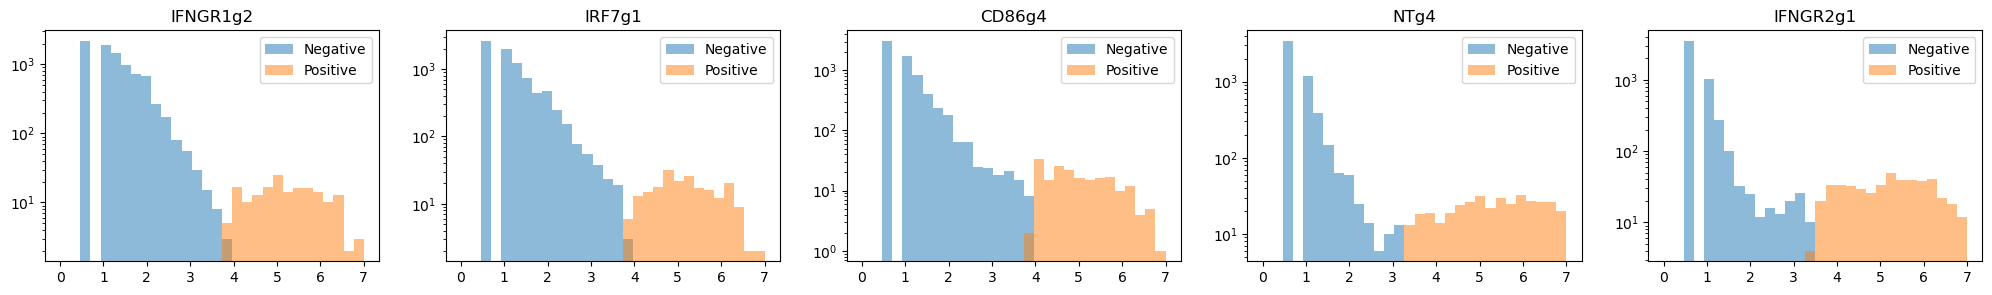

In [24]:
# Inspect for single guide expression distributions
guides = gdo.var.sort_values("guide_counts", ascending=False).index[:5]
fig, axs = plt.subplots(1, len(guides), figsize=(5 * len(guides), 3))

from pertpy.preprocessing._guide_rna_mixture import Poisson_Gauss_Mixture

for guide, ax in zip(guides, axs, strict=False):
    print(guide)
    data = gdo[:, guide].X.todense().A1

    mixture_model = Poisson_Gauss_Mixture()
    is_nonzero = data != 0
    data_nonzero = data[is_nonzero]
    assignments = mixture_model.run_model(data_nonzero)

    gdo.obs["guide_assignment"] = "Negative"
    gdo.obs.loc[gdo.obs_names[is_nonzero], "guide_assignment"] = assignments

    ax.hist(data_nonzero[assignments == "Negative"], bins=30, range=(0, 7), alpha=0.5, label="Negative")
    ax.hist(data_nonzero[assignments == "Positive"], bins=30, range=(0, 7), alpha=0.5, label="Positive")
    ax.set_yscale("log")
    ax.legend()
    ax.set_title(guide)
plt.show()